![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

Automate product tagging for the e-commerce store using CNNs.

Once trained (keeping the epochs to 1 or 2 to keep the run time down), store your predictions on the test set in a list named predictions.

Calculate the accuracy, and per-class precision and recall for your classifier based on the predictions obtained. Store your metrics in variables named accuracy, precision, and recall. Use lists of the appropriate length for the precision and recall.

# Package imports

In [20]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision

In [29]:
#Define a transform to normalize the data
from torchvision import transforms

# Train transforms (có augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Test transforms (không augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Reading and transforming the image data
- Training
- Validation

In [32]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transform)
test_dataset  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=test_transform)

dataloader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [34]:
classes = train_dataset.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [35]:
print(train_dataset.class_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [36]:
def imshow(sample_element, shape = (28, 28)):
    plt.imshow(sample_element[0].reshape(shape), cmap='gray')
    plt.title('Label = ' + str(sample_element[1]))
    plt.show()

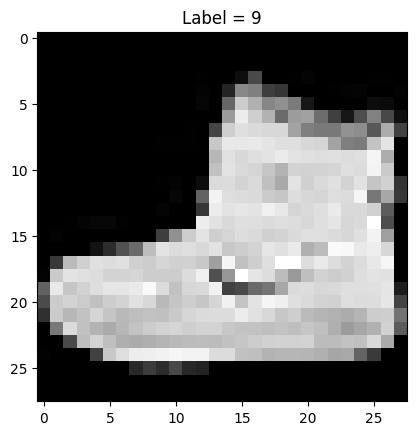

In [25]:
imshow(train_data[0])

**1. Defining the CNN (Convolutional Neural Network) **

Define a class containing all the appropriate layers, and a method to perform the forward pass of a batch of images.

- Creating a class to contain the layers of a CNN
    * You could define a class that inherits from PyTorch's nn.module class.

- Adding a convolutional layer
    * You could use PyTorch's nn.Conv2D() class to define the convolutional layer.
    * Create an instance of it in your CNN class's constructor and assign it to an instance variable such as self.conv.

- Adding a Rectilinear Unit
    * You could use PyTorch's nn.ReLU() class.
    * Create an instance of it in your CNN class's constructor and assign it to an instance variable such as self.relu.

- Adding a pooling layer
    * You could use PyTorch's nn.MaxPool2D() class.
    * Create an instance of it in your CNN class's constructor and assign it to an instance variable such as self.maxpool.

- Adding a fully connected layer
    * You could use PyTorch's nn.Linear() class.
    * Create an instance of it in your CNN class's constructor and assign it to an instance variable such as self.fc.
    * You will also need to flatten the input first, which could be done with an instance of nn.Flatten

- Defining a .forward() method
    * Finally, you'll need to define a .forward() method that passes the input through each layer and returns the output.

In [48]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(32*14*14, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [49]:
print(CNN(num_classes=10))

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=6272, out_features=10, bias=True)
)


**2. Training the CNN**
Define a training loop that loops over the dataset, calculating the loss and propagating it backwards through the network.

- Define a suitable loss criterion
    * PyTorch's nn.CrossEntropyLoss() could be used here, since this is a multi-class classification problem.

- Define an optimizer
    * You could use PyTorch's optim.Adam() optimizer here.


In [50]:
# Define the model
model = CNN(num_classes=10)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.5112
Epoch 2, Loss: 0.3833
Epoch 3, Loss: 0.3528


**3. Testing the CNN**
Use your trained model to classify the images in the test set, and calculate the appropriate metrics.

- Predict the category of each image in the test data.
    * You'll need to use the .forward() method on your CNN class to pass the test images through the network.
    * You could use torch.argmax() to find the category with the highest predicted probability.

- Calculate the performance metrics
    * You could use Accuracy(), Precision(), and Recall() from torchmetrics to calculate the metrics.

In [52]:
from torchmetrics import Recall, Precision
#Define metrics
metric_precision = Precision(task="multiclass", num_classes=10, average=None)
metric_recall = Recall(task='multiclass', num_classes=10, average=None)

model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: tensor([0.8704, 0.9789, 0.7898, 0.8680, 0.8167, 0.9807, 0.6801, 0.8871, 0.9717,
        0.9465])
Recall: tensor([0.7790, 0.9760, 0.8640, 0.8810, 0.8110, 0.9150, 0.6760, 0.9740, 0.9620,
        0.9380])


In [53]:
# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in test_dataset.class_to_idx.items()
}
print(precision_per_class)

{'T-shirt/top': 0.8703910708427429, 'Trouser': 0.9789367914199829, 'Pullover': 0.7897623181343079, 'Dress': 0.8679803013801575, 'Coat': 0.8167170286178589, 'Sandal': 0.9807074069976807, 'Shirt': 0.6800804734230042, 'Sneaker': 0.8870673775672913, 'Bag': 0.9717171788215637, 'Ankle boot': 0.9465186595916748}


In [54]:
#Get Recall per class
recall_per_class = {
    k: recall[v].item()
    for k, v
    in test_dataset.class_to_idx.items()
}
print(recall_per_class)

{'T-shirt/top': 0.7789999842643738, 'Trouser': 0.9760000109672546, 'Pullover': 0.8640000224113464, 'Dress': 0.8809999823570251, 'Coat': 0.8109999895095825, 'Sandal': 0.9150000214576721, 'Shirt': 0.6759999990463257, 'Sneaker': 0.9739999771118164, 'Bag': 0.9620000123977661, 'Ankle boot': 0.9380000233650208}
